## Configuration

In [14]:
# Core libraries
import pandas as pd
import numpy as np
import os
import random
from datetime import datetime
import warnings

# Graph libraries
import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms.centrality import degree_centrality, closeness_centrality
from networkx.algorithms.link_analysis.pagerank_alg import pagerank
from networkx.algorithms.link_analysis.hits_alg import hits
import igraph as ig
import leidenalg as la

# Machine learning libraries
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.metrics.pairwise import cosine_similarity
import lightgbm as lgb

# Deep learning libraries
import torch
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv

import sys


warnings.filterwarnings('ignore')

In [15]:
# Load environment variables
import os
from dotenv import load_dotenv
from pathlib import Path

# Try to load .env from multiple locations
env_paths = [
    Path(r'C:\Users\potda\Daniel\BGU\Year_D\Final_Project\Social-Network-Stock-Market\.env'),
    Path.cwd() / '.env',  # Current directory
    Path.cwd().parent / '.env',  # Parent directory (project root)
]

for env_path in env_paths:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Loaded environment from: {env_path}")
        break
else:
    print("No .env file found in any of the checked locations")

# Now you can use os.getenv() to access your variables

Loaded environment from: C:\Users\potda\Daniel\BGU\Year_D\Final_Project\Social-Network-Stock-Market\.env


In [16]:
# Verify database environment variables are loaded
print("\nDatabase configuration:")
print(f"  DB_HOST: {os.getenv('DB_HOST', 'Not set')}")
print(f"  DB_PORT: {os.getenv('DB_PORT', 'Not set')}")
print(f"  DB_NAME: {os.getenv('DB_NAME', 'Not set')}")
print(f"  DB_USER: {os.getenv('DB_USER', 'Not set')}")
print(f"  DB_PASSWORD: {'*' * len(os.getenv('DB_PASSWORD', '')) if os.getenv('DB_PASSWORD') else 'Not set'}")


Database configuration:
  DB_HOST: 127.0.0.1
  DB_PORT: 5432
  DB_NAME: Social_13F
  DB_USER: postgres
  DB_PASSWORD: *******


In [17]:
# Calculate project root path
# If notebook is in Notebooks/LightGCN/, go up 2 levels to project root
notebook_path = Path.cwd()  # Current working directory
project_root = notebook_path.parent.parent  # Go up 2 levels

# Add project root to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python path includes: {str(project_root) in sys.path}")



Project root: c:\Users\potda\Daniel\BGU\Year_D\Final_Project\Social-Network-Stock-Market
Python path includes: True


In [18]:
from ETL.data_handlers.db_data_handler.postgres_handler import PostgresHandler

In [19]:
# ============================================================================
# GPU Diagnostics
# ============================================================================

def check_gpu_support():
    """Check PyTorch CUDA support and GPU availability."""
    print("PyTorch Version:", torch.__version__)
    print("CUDA Available:", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("\n⚠ CUDA not available!")
        print("Possible reasons:")
        print("1. PyTorch installed without CUDA support (CPU-only version)")
        print("2. CUDA drivers not installed")
        print("3. PyTorch version incompatible with CUDA version")
        print("\nTo install PyTorch with CUDA support:")
        print("Visit: https://pytorch.org/get-started/locally/")
        print("Or run: pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

check_gpu_support()

PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [20]:
# Device Configuration
def get_device():
    """Get available device (CUDA if available, else CPU)."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print(f"✓ Using CPU")
    return device

# Set device
device = get_device()

✓ Using GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


## Loading the Data

In [21]:
import pandas as pd
# Import database handler (it will use the environment variables we just loaded)
# Connect to database using environment variables
print("\nConnecting to database...")
handler = PostgresHandler()

if not handler.connect():
    raise ConnectionError("Failed to connect to database")

print(f"✓ Connected to database: {handler.database}")

# Query to load holdings_filtered_new where period_start = '2024-01-01'
query = """
SELECT 
    hf.nameofissuer,
    hf.cusip,
    hf.sshprnamt,
    hf.cik,
    hf.period_start,
    tp.price
FROM holdings_filtered_new hf
INNER JOIN ticker_to_cusip ttc ON hf.cusip = ttc.cusip
INNER JOIN ticker_prices tp ON ttc.ticker = tp.ticker 
    AND hf.period_start = CAST(tp.period_start AS DATE)
WHERE hf.period_start = '2024-01-01'
"""

print("\nLoading data from holdings_filtered_new where period_start = '2024-01-01'...")
df = pd.read_sql_query(query, handler.connection)
print(f"✓ Loaded {len(df):,} rows")
print(f"\nDataFrame shape: {df.shape}")

# Display first few rows
if len(df) > 0:
    print("\nFirst 5 rows:")
    print(df.head())
else:
    print("\n⚠ No data found for period_start = '2024-01-01'")

# Close connection
handler.disconnect()
print("\n✓ Database connection closed")

# Now you can use the DataFrame 'df' for your analysis

2026-01-14 23:57:45 - ETL_Pipeline - INFO - Connected to PostgreSQL: postgres@127.0.0.1:5432/Social_13F



Connecting to database...
✓ Connected to database: Social_13F

Loading data from holdings_filtered_new where period_start = '2024-01-01'...


2026-01-14 23:57:51 - ETL_Pipeline - INFO - Disconnected from PostgreSQL


✓ Loaded 1,723,925 rows

DataFrame shape: (1723925, 6)

First 5 rows:
         nameofissuer      cusip  sshprnamt         cik period_start     price
0     ABBOTT LABS COM  002824100     1863.0  0001800597   2024-01-01  108.3693
1          ABBVIE INC  00287Y109     5839.0  0001800597   2024-01-01  170.0935
2           AFLAC INC  001055102     5450.0  0001800597   2024-01-01   82.1170
3  ALLIANT CORP STOCK  018802108     4506.0  0001800597   2024-01-01   46.8504
4      AMAZON COM INC  023135106     1488.0  0001800597   2024-01-01  180.9700

✓ Database connection closed


## Describe the data

In [24]:
# Filter Zero Values

print(f"Before filtering: {len(df):,} rows")
print(f"  - sshprnamt = 0: {(df['sshprnamt'] == 0).sum():,}")
print(f"  - price = 0: {(df['price'] == 0).sum():,}")

# Filter out zeros
df = df[(df['sshprnamt'] != 0) & (df['price'] != 0)].copy()

print(f"\nAfter filtering: {len(df):,} rows")
print(f"✓ Removed {(df['sshprnamt'] == 0).sum() + (df['price'] == 0).sum():,} rows with zero values")

Before filtering: 1,723,925 rows
  - sshprnamt = 0: 3,730
  - price = 0: 0

After filtering: 1,720,195 rows
✓ Removed 0 rows with zero values


In [25]:
df.describe()

,sshprnamt,price
count,1.720195e+06,1.720195e+06
mean,2.483841e+05,1.379459e+02
std,3.059934e+06,2.731320e+02
min,1.000000e+00,7.000000e-04
25%,1.061000e+03,3.217230e+01
50%,8.390000e+03,7.612000e+01
75%,5.058250e+04,1.667420e+02
max,1.255168e+09,8.026270e+03


In [30]:
# Quick View of Duplicate Pairs

def quick_view_duplicates(df):
    """
    Quick view of duplicate pairs with summary.
    """
    # Find duplicates
    duplicates = df[df.duplicated(subset=['cik', 'cusip'], keep=False)]
    
    if len(duplicates) == 0:
        print("✓ No duplicate pairs found!")
        return
    
    # Group by (cik, cusip) and show details
    duplicate_groups = duplicates.groupby(['cik', 'cusip'])
    
    print(f"Found {len(duplicate_groups):,} duplicate pairs ({len(duplicates):,} total rows)")
    print("\nFirst 10 duplicate pairs:\n")
    
    for idx, ((cik, cusip), group) in enumerate(duplicate_groups, 1):
        if idx > 10:
            break
        
        print(f"Pair {idx}: CIK={cik}, CUSIP={cusip}")
        print(f"  Occurrences: {len(group)}")
        print(f"  Weights: {group['weight'].tolist()}")
        print(f"  Names: {group['nameofissuer'].unique().tolist()}")
        print()
    
    # Return the duplicates DataFrame for further inspection
    return duplicates.sort_values(['cik', 'cusip'])

# Quick view
duplicate_df = quick_view_duplicates(df)


Found 205,662 duplicate pairs (842,948 total rows)

First 10 duplicate pairs:

Pair 1: CIK=0000003520, CUSIP=000361105
  Occurrences: 2
  Weights: [1322599.5, 29461544.4]
  Names: ['AAR CORP']

Pair 2: CIK=0000003520, CUSIP=004225108
  Occurrences: 2
  Weights: [1931615.84, 39291502.800000004]
  Names: ['ACADIA PHARMACEUTICALS INC']

Pair 3: CIK=0000003520, CUSIP=00847J105
  Occurrences: 2
  Weights: [13686389.85, 64389186.15]
  Names: ['AGILYSYS INC']

Pair 4: CIK=0000003520, CUSIP=125141101
  Occurrences: 2
  Weights: [7964555.0, 350865.0]
  Names: ['CECO ENVIRONMENTAL CORP']

Pair 5: CIK=0000003520, CUSIP=12763L105
  Occurrences: 2
  Weights: [491546.1992, 11166380.899799999]
  Names: ['CADRE HOLDINGS INC']

Pair 6: CIK=0000003520, CUSIP=147448104
  Occurrences: 2
  Weights: [113906202.0, 5288649.5]
  Names: ['CASELLA WASTE SYSTEMS']

Pair 7: CIK=0000003520, CUSIP=21867A105
  Occurrences: 2
  Weights: [585701.85, 14116898.021999998]
  Names: ['CORE LABORATORIES INC']

Pair 8: CIK=00

In [31]:
# Merge Duplicate Rows (With Details)

def merge_duplicate_rows_detailed(df):
    """
    Merge rows with detailed reporting of what was merged.
    """
    print("=" * 80)
    print("Merging Duplicate Rows (Detailed)")
    print("=" * 80)
    
    original_count = len(df)
    print(f"Original rows: {original_count:,}\n")
    
    # Find duplicates before merging
    duplicates = df[df.duplicated(subset=['cik', 'cusip'], keep=False)]
    duplicate_groups = duplicates.groupby(['cik', 'cusip'])
    
    print(f"Found {len(duplicate_groups):,} duplicate pairs")
    
    # Count how many will be summed vs removed
    summed_count = 0
    removed_count = 0
    
    for (cik, cusip), group in duplicate_groups:
        if group['sshprnamt'].nunique() == 1:
            removed_count += len(group) - 1  # Keep 1, remove rest
        else:
            summed_count += len(group) - 1   # Sum into 1
    
    print(f"  - Pairs with identical sshprnamt: {sum(1 for _, g in duplicate_groups if g['sshprnamt'].nunique() == 1):,}")
    print(f"  - Pairs with different sshprnamt: {sum(1 for _, g in duplicate_groups if g['sshprnamt'].nunique() > 1):,}")
    print(f"  - Rows to be removed (identical): {removed_count:,}")
    print(f"  - Rows to be summed (different): {summed_count:,}")
    
    # Perform merge
    print("\nMerging...")
    agg_dict = {
        'sshprnamt': 'sum',
        'price': 'first',
        'nameofissuer': 'first',
        'period_start': 'first'
    }
    
    df_merged = df.groupby(['cik', 'cusip'], as_index=False).agg(agg_dict)
    df_merged['weight'] = df_merged['sshprnamt'] * df_merged['price']
    
    final_count = len(df_merged)
    
    print("\n" + "=" * 80)
    print("Merge Complete")
    print("=" * 80)
    print(f"Original rows: {original_count:,}")
    print(f"Merged rows: {final_count:,}")
    print(f"Reduction: {original_count - final_count:,} rows ({100*(original_count-final_count)/original_count:.2f}%)")
    print("=" * 80)
    
    return df_merged

# Merge with details
df = merge_duplicate_rows_detailed(df)

Merging Duplicate Rows (Detailed)
Original rows: 1,720,195

Found 205,662 duplicate pairs
  - Pairs with identical sshprnamt: 17,313
  - Pairs with different sshprnamt: 188,349
  - Rows to be removed (identical): 17,931
  - Rows to be summed (different): 619,355

Merging...

Merge Complete
Original rows: 1,720,195
Merged rows: 1,082,909
Reduction: 637,286 rows (37.05%)


In [35]:
df.shape

(1082909, 7)

## Building The graph

In [36]:
from multiprocessing import Pool, cpu_count
import numpy as np
from tqdm import tqdm


In [37]:
# ============================================================================
# Step 1: Build Bipartite Graph (Fastest with Progress Bar)
# ============================================================================

def calculate_edge_weights(df):
    """Calculate edge weights as sshprnamt * price."""
    df['weight'] = df['sshprnamt'] * df['price']
    return df

def build_bipartite_graph_fastest(df):
    """
    Fastest method using pure vectorized operations with progress tracking.
    Uses add_weighted_edges_from for optimal performance.
    """
    import time
    start = time.time()
    
    print("=" * 60)
    print("Building Bipartite Graph (Optimized)")
    print("=" * 60)
    
    # Step 1: Calculate weights
    print("\n[1/4] Calculating edge weights...")
    weight_start = time.time()
    df = calculate_edge_weights(df)
    print(f"     ✓ Completed in {time.time() - weight_start:.2f}s")
    
    # Step 2: Create graph and add nodes
    print("\n[2/4] Creating graph and adding nodes...")
    node_start = time.time()
    
    G = nx.Graph()
    
    funds = df['cik'].unique()
    G.add_nodes_from(funds, bipartite=0)
    
    stocks = df['cusip'].unique()
    G.add_nodes_from(stocks, bipartite=1)
    
    print(f"     ✓ Added {len(funds):,} funds and {len(stocks):,} stocks in {time.time() - node_start:.2f}s")
    
    # Step 3: Create edge list (vectorized - fastest)
    print("\n[3/4] Creating edge list (vectorized)...")
    edge_start = time.time()
    
    # Progress bar for edge creation
    with tqdm(total=len(df), desc="     Processing edges", unit="edges", unit_scale=True) as pbar:
        # Vectorized edge creation - fastest method
        edges = list(zip(
            df['cik'].values,
            df['cusip'].values,
            df['weight'].values
        ))
        pbar.update(len(df))
    
    print(f"     ✓ Created {len(edges):,} edges in {time.time() - edge_start:.2f}s")
    
    # Step 4: Add edges to graph
    print("\n[4/4] Adding edges to graph...")
    add_start = time.time()
    
    # Use add_weighted_edges_from - fastest method
    with tqdm(total=1, desc="     Adding to graph") as pbar:
        G.add_weighted_edges_from(edges, weight='weight')
        pbar.update(1)
    
    print(f"     ✓ Added edges in {time.time() - add_start:.2f}s")
    
    # Summary
    elapsed = time.time() - start
    print("\n" + "=" * 60)
    print("Construction Complete")
    print("=" * 60)
    print(f"Total time: {elapsed:.2f}s ({elapsed/60:.2f} min)")
    print(f"Speed: {len(df)/elapsed:,.0f} edges/second")
    print(f"Nodes: {G.number_of_nodes():,}")
    print(f"Edges: {G.number_of_edges():,}")
    print("=" * 60)
    
    return G, funds, stocks

# Build the graph (replace Cell 11 with this)
print("Building bipartite graph (optimized)...")
G_bipartite, funds, stocks = build_bipartite_graph_fastest(df)

print(f"\n✓ Graph created: {G_bipartite.number_of_nodes():,} nodes, {G_bipartite.number_of_edges():,} edges")
print(f"  - Funds (CIK): {len(funds):,}")
print(f"  - Stocks (CUSIP): {len(stocks):,}")

Building bipartite graph (optimized)...
Building Bipartite Graph (Optimized)

[1/4] Calculating edge weights...
     ✓ Completed in 0.01s

[2/4] Creating graph and adding nodes...
     ✓ Added 7,058 funds and 2,911 stocks in 0.08s

[3/4] Creating edge list (vectorized)...


     Processing edges: 100%|██████████| 1.08M/1.08M [00:00<00:00, 5.48Medges/s]


     ✓ Created 1,082,909 edges in 0.20s

[4/4] Adding edges to graph...


     Adding to graph: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

     ✓ Added edges in 1.70s

Construction Complete
Total time: 1.99s (0.03 min)
Speed: 545,378 edges/second
Nodes: 9,969
Edges: 1,082,909

✓ Graph created: 9,969 nodes, 1,082,909 edges
  - Funds (CIK): 7,058
  - Stocks (CUSIP): 2,911


In [39]:
# Graph Validation: Detailed Test

def detailed_validate_graph(df, G, num_samples=10):
    """
    Detailed validation with edge-by-edge comparison.
    """
    sample_df = df.sample(n=min(num_samples, len(df)), random_state=42)
    
    print("=" * 80)
    print("Graph Validation Report")
    print("=" * 80)
    
    validation_data = []
    
    for idx, (_, row) in enumerate(sample_df.iterrows(), 1):
        cik = row['cik']
        cusip = row['cusip']
        expected_weight = row['weight']
        
        exists = G.has_edge(cik, cusip)
        actual_weight = G[cik][cusip]['weight'] if exists else None
        weight_ok = abs(actual_weight - expected_weight) < 1e-6 if exists else False
        
        validation_data.append({
            'test_num': idx,
            'cik': cik,
            'cusip': cusip,
            'exists': exists,
            'weight_ok': weight_ok,
            'expected': expected_weight,
            'actual': actual_weight
        })
        
        status = "PASS" if (exists and weight_ok) else "FAIL"
        print(f"\nTest {idx}: {status}")
        print(f"  CIK: {cik}")
        print(f"  CUSIP: {cusip}")
        print(f"  Edge exists: {exists}")
        if exists:
            print(f"  Weight match: {weight_ok}")
            print(f"  Expected: {expected_weight:.6f}")
            print(f"  Actual: {actual_weight:.6f}")
    
    print("\n" + "=" * 80)
    
    # Summary
    passed = sum(1 for v in validation_data if v['exists'] and v['weight_ok'])
    total = len(validation_data)
    
    print(f"Summary: {passed}/{total} tests passed ({100*passed/total:.1f}%)")
    
    if passed == total:
        print("✓ Graph construction validated successfully!")
    else:
        print("⚠ Some validation tests failed")
    
    return validation_data

# Run detailed validation
validation_data = detailed_validate_graph(df, G_bipartite, num_samples=10)

Graph Validation Report

Test 1: PASS
  CIK: 0000807249
  CUSIP: 307675108
  Edge exists: True
  Weight match: True
  Expected: 2805480.000000
  Actual: 2805480.000000

Test 2: PASS
  CIK: 0001890698
  CUSIP: 478160104
  Edge exists: True
  Weight match: True
  Expected: 229371.196600
  Actual: 229371.196600

Test 3: PASS
  CIK: 0001512404
  CUSIP: 25809K105
  Edge exists: True
  Weight match: True
  Expected: 402031.000000
  Actual: 402031.000000

Test 4: PASS
  CIK: 0001801619
  CUSIP: 74276R102
  Edge exists: True
  Weight match: True
  Expected: 2015.060000
  Actual: 2015.060000

Test 5: PASS
  CIK: 0000884548
  CUSIP: 17275R102
  Edge exists: True
  Weight match: True
  Expected: 417369.579200
  Actual: 417369.579200

Test 6: PASS
  CIK: 0001801507
  CUSIP: 46625H100
  Edge exists: True
  Weight match: True
  Expected: 1541078.396000
  Actual: 1541078.396000

Test 7: PASS
  CIK: 0001126328
  CUSIP: 060505104
  Edge exists: True
  Weight match: True
  Expected: 544837722.483600
  A

In [49]:
# ============================================================================
# Step 1: Split Edges into Train/Val/Test (80/10/10)
# ============================================================================

def split_dataframe_edges(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    """
    Split DataFrame edges into train, validation, and test sets.
    Ensures all nodes appear in training set.
    """
    import time
    start = time.time()
    
    print("=" * 60)
    print("Splitting Edges into Train/Val/Test")
    print("=" * 60)
    
    # Set random seed
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    # Shuffle DataFrame
    print("\n[1/3] Shuffling data...")
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    
    # Calculate split sizes
    total = len(df_shuffled)
    train_size = int(total * train_ratio)
    val_size = int(total * val_ratio)
    
    # Split
    print("\n[2/3] Splitting edges...")
    train_df = df_shuffled.iloc[:train_size].copy()
    val_df = df_shuffled.iloc[train_size:train_size + val_size].copy()
    test_df = df_shuffled.iloc[train_size + val_size:].copy()
    
    # Verify all nodes are in training set
    print("\n[3/3] Verifying node coverage...")
    train_funds = set(train_df['cik'].unique())
    train_stocks = set(train_df['cusip'].unique())
    
    val_funds = set(val_df['cik'].unique())
    val_stocks = set(val_df['cusip'].unique())
    test_funds = set(test_df['cik'].unique())
    test_stocks = set(test_df['cusip'].unique())
    
    # Check for nodes only in val/test
    val_only_funds = val_funds - train_funds
    val_only_stocks = val_stocks - train_stocks
    test_only_funds = test_funds - train_funds
    test_only_stocks = test_stocks - train_stocks
    
    if val_only_funds or val_only_stocks or test_only_funds or test_only_stocks:
        print(f"  ⚠ Warning: Some nodes only in val/test sets")
        print(f"    Moving {len(val_only_funds) + len(val_only_stocks) + len(test_only_funds) + len(test_only_stocks)} edges to train...")
        
        # Move edges with new nodes to train
        val_new = val_df[val_df['cik'].isin(val_only_funds) | val_df['cusip'].isin(val_only_stocks)]
        test_new = test_df[test_df['cik'].isin(test_only_funds) | test_df['cusip'].isin(test_only_stocks)]
        
        train_df = pd.concat([train_df, val_new, test_new], ignore_index=True)
        val_df = val_df[~val_df.index.isin(val_new.index)]
        test_df = test_df[~test_df.index.isin(test_new.index)]
    
    elapsed = time.time() - start
    
    print("\n" + "=" * 60)
    print("Split Complete")
    print("=" * 60)
    print(f"Total edges: {total:,}")
    print(f"Train: {len(train_df):,} ({100*len(train_df)/total:.1f}%)")
    print(f"Validation: {len(val_df):,} ({100*len(val_df)/total:.1f}%)")
    print(f"Test: {len(test_df):,} ({100*len(test_df)/total:.1f}%)")
    print(f"Time: {elapsed:.2f}s")
    print("=" * 60)
    
    return train_df, val_df, test_df

# Split the data
print("Splitting edges...")
train_df, val_df, test_df = split_dataframe_edges(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

Splitting edges...
Splitting Edges into Train/Val/Test

[1/3] Shuffling data...

[2/3] Splitting edges...

[3/3] Verifying node coverage...
  ⚠ Warning: Some nodes only in val/test sets
    Moving 74 edges to train...

Split Complete
Total edges: 1,082,909
Train: 866,406 (80.0%)
Validation: 108,254 (10.0%)
Test: 108,249 (10.0%)
Time: 7.00s


In [50]:
# Step 2: Build Separate Graphs (Train, Train+Val, Full)

def build_graphs_from_splits(train_df, val_df):
    """
    Build separate graphs for training and validation.
    """
    import time
    start = time.time()
    
    print("=" * 60)
    print("Building Graphs from Splits")
    print("=" * 60)
    
    # Build train graph
    print("\n[1/2] Building training graph...")
    G_train, funds_train, stocks_train = build_bipartite_graph_fastest(train_df)
    
    # Build train+val graph (for validation)
    print("\n[2/2] Building train+validation graph...")
    train_val_df = pd.concat([train_df, val_df], ignore_index=True)
    G_train_val, funds_train_val, stocks_train_val = build_bipartite_graph_fastest(train_val_df)
    
    elapsed = time.time() - start
    
    print("\n" + "=" * 60)
    print("Graphs Built")
    print("=" * 60)
    print(f"Train graph: {G_train.number_of_nodes():,} nodes, {G_train.number_of_edges():,} edges")
    print(f"Train+Val graph: {G_train_val.number_of_nodes():,} nodes, {G_train_val.number_of_edges():,} edges")
    print(f"Time: {elapsed:.2f}s")
    print("=" * 60)
    
    return G_train, G_train_val, funds_train, stocks_train

# Build graphs
G_train, G_train_val, funds_train, stocks_train = build_graphs_from_splits(train_df, val_df)

Building Graphs from Splits

[1/2] Building training graph...
Building Bipartite Graph (Optimized)

[1/4] Calculating edge weights...
     ✓ Completed in 0.01s

[2/4] Creating graph and adding nodes...
     ✓ Added 7,058 funds and 2,911 stocks in 0.15s

[3/4] Creating edge list (vectorized)...


     Processing edges: 100%|██████████| 866k/866k [00:00<00:00, 1.44Medges/s]


     ✓ Created 866,406 edges in 0.61s

[4/4] Adding edges to graph...


     Adding to graph: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


     ✓ Added edges in 2.31s

Construction Complete
Total time: 3.08s (0.05 min)
Speed: 280,957 edges/second
Nodes: 9,969
Edges: 866,406

[2/2] Building train+validation graph...
Building Bipartite Graph (Optimized)

[1/4] Calculating edge weights...
     ✓ Completed in 0.02s

[2/4] Creating graph and adding nodes...
     ✓ Added 7,058 funds and 2,911 stocks in 0.17s

[3/4] Creating edge list (vectorized)...


     Processing edges: 100%|██████████| 975k/975k [00:00<00:00, 1.57Medges/s]


     ✓ Created 974,660 edges in 0.63s

[4/4] Adding edges to graph...


     Adding to graph: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


     ✓ Added edges in 2.37s

Construction Complete
Total time: 3.19s (0.05 min)
Speed: 305,259 edges/second
Nodes: 9,969
Edges: 974,660

Graphs Built
Train graph: 9,969 nodes, 866,406 edges
Train+Val graph: 9,969 nodes, 974,660 edges
Time: 6.62s


In [51]:
# Step 3: Create Node Mappings

print("Creating node mappings...")
node_to_idx, fund_to_idx, stock_to_idx = create_node_mappings(funds_train, stocks_train)

print(f"✓ Node mappings created")
print(f"  - Funds: {len(fund_to_idx):,}")
print(f"  - Stocks: {len(stock_to_idx):,}")
print(f"  - Total nodes: {len(node_to_idx):,}")

Creating node mappings...
✓ Node mappings created
  - Funds: 7,058
  - Stocks: 2,911
  - Total nodes: 9,969


In [52]:
# Step 4: Convert Graphs to PyTorch Geometric Format

# Convert train graph
print("Converting train graph to PyG format...")
train_edge_index, train_edge_weights = graph_to_edge_index_fastest(G_train, node_to_idx, device)

# Convert train+val graph (for validation)
print("\nConverting train+val graph to PyG format...")
train_val_edge_index, train_val_edge_weights = graph_to_edge_index_fastest(G_train_val, node_to_idx, device)

print(f"\n✓ Edge indices created")
print(f"  - Train edges: {train_edge_index.shape[1]:,}")
print(f"  - Train+Val edges: {train_val_edge_index.shape[1]:,}")

Converting train graph to PyG format...
Converting Graph to PyTorch Geometric Format

[1/4] Extracting edges from graph...
     ✓ Extracted 866,406 edges in 0.66s

[2/4] Processing edge data...


     Processing: 100%|██████████| 866k/866k [00:00<00:00, 1.19Medges/s]


     ✓ Processed in 0.73s

[3/4] Mapping nodes to indices...


     Mapping: 100%|██████████| 866k/866k [00:00<00:00, 2.53Medges/s]


     ✓ Mapped in 0.35s

[4/4] Creating bidirectional edges and moving to device...


     Moving to device: 100%|██████████| 2/2 [00:00<00:00, 29.31it/s]



     ✓ Completed in 0.13s

Conversion Complete
Total time: 1.86s
Speed: 465,105 edges/second
Edge index shape: torch.Size([2, 1732812]) (on cuda)
Edge weights shape: torch.Size([1732812]) (on cuda)
Total bidirectional edges: 1,732,812

Converting train+val graph to PyG format...
Converting Graph to PyTorch Geometric Format

[1/4] Extracting edges from graph...
     ✓ Extracted 974,660 edges in 3.15s

[2/4] Processing edge data...


     Processing: 100%|██████████| 975k/975k [00:00<00:00, 1.19Medges/s]


     ✓ Processed in 0.82s

[3/4] Mapping nodes to indices...


     Mapping: 100%|██████████| 975k/975k [00:00<00:00, 2.99Medges/s]


     ✓ Mapped in 0.33s

[4/4] Creating bidirectional edges and moving to device...


     Moving to device: 100%|██████████| 2/2 [00:00<00:00, 54.55it/s]


     ✓ Completed in 0.06s

Conversion Complete
Total time: 4.35s
Speed: 223,825 edges/second
Edge index shape: torch.Size([2, 1949320]) (on cuda)
Edge weights shape: torch.Size([1949320]) (on cuda)
Total bidirectional edges: 1,949,320

✓ Edge indices created
  - Train edges: 1,732,812
  - Train+Val edges: 1,949,320


In [56]:
# Step 5: Create Training and Validation Pairs (FIXED)

# Training pairs (from train graph only)
print("Creating training pairs...")
train_pos_edges, train_neg_edges = create_positive_negative_pairs_fastest(
    train_edge_index, num_nodes, device, num_negatives=1
)

# Validation pairs (from train+val graph, but only validate on val edges)
print("\nCreating validation pairs...")
# Get validation edges only
val_edge_pairs = []
for _, row in val_df.iterrows():
    if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
        val_edge_pairs.append([fund_to_idx[row['cik']], stock_to_idx[row['cusip']]])

val_pos_edges = torch.tensor(val_edge_pairs, dtype=torch.long).to(device)

# Sample negative edges for validation - FIXED to ensure exact count
print(f"Sampling {len(val_pos_edges):,} negative edges for validation...")
val_neg_edges = []
val_pos_set = set((u.item(), v.item()) for u, v in val_pos_edges)

# Get all possible edges from train+val graph to avoid sampling from them
train_val_set = set()
for i in tqdm(range(train_val_edge_index.shape[1]), desc="Building train+val edge set"):
    u = train_val_edge_index[0, i].item()
    v = train_val_edge_index[1, i].item()
    train_val_set.add((u, v))
    train_val_set.add((v, u))  # Add both directions

# Sample negative edges that are NOT in train+val graph
max_attempts = len(val_pos_edges) * 100  # Limit attempts
attempts = 0
while len(val_neg_edges) < len(val_pos_edges) and attempts < max_attempts:
    u = random.randint(0, num_nodes - 1)
    v = random.randint(0, num_nodes - 1)
    if u != v and (u, v) not in train_val_set:
        val_neg_edges.append([u, v])
    attempts += 1

# If we didn't get enough, fill with random edges (even if they might be in train)
if len(val_neg_edges) < len(val_pos_edges):
    print(f"  ⚠ Warning: Only sampled {len(val_neg_edges):,} negatives, filling rest...")
    while len(val_neg_edges) < len(val_pos_edges):
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if u != v and (u, v) not in val_pos_set:
            val_neg_edges.append([u, v])

val_neg_edges = torch.tensor(val_neg_edges[:len(val_pos_edges)], dtype=torch.long).to(device)

print(f"\n✓ Training pairs: {len(train_pos_edges):,} pos, {len(train_neg_edges):,} neg")
print(f"✓ Validation pairs: {len(val_pos_edges):,} pos, {len(val_neg_edges):,} neg")
assert len(val_pos_edges) == len(val_neg_edges), f"Mismatch: {len(val_pos_edges)} pos vs {len(val_neg_edges)} neg"

Creating training pairs...
Creating Training Pairs

[1/3] Extracting positive edges...


     Extracting: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


     ✓ Extracted 1,732,812 positive edges in 0.26s

[2/3] Creating positive edge set...


     Building set: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


     ✓ Created set in 2.17s

[3/3] Sampling 1x negative edges...


     Sampling negatives: 1.75Medges [00:03, 530kedges/s]                        


     ✓ Sampled 1,732,812 negative edges in 3.31s

[4/4] Creating tensors and moving to device...


     Creating tensors: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


     ✓ Completed in 0.50s

Training Pairs Created
Total time: 6.24s
Positive edges: 1,732,812
Negative edges: 1,732,812
Ratio: 1.00x
Device: cuda

Creating validation pairs...
Sampling 108,254 negative edges for validation...


Building train+val edge set: 100%|██████████| 1949320/1949320 [09:52<00:00, 3291.68it/s]



✓ Training pairs: 1,732,812 pos, 1,732,812 neg
✓ Validation pairs: 108,254 pos, 108,254 neg


In [57]:
# Step 6: Initialize Fresh Model

# Initialize new model for training
print("Initializing fresh model...")
model = initialize_model_fastest(
    num_nodes=num_nodes,
    embedding_dim=64,
    num_layers=3,
    device=device
)

print(f"\n✓ Model ready for training")

Initializing fresh model...
Initializing LightGCN Model

[1/2] Creating model...


     Building model: 100%|██████████| 1/1 [00:00<00:00, 53.80it/s]



[2/2] Moving to device...


     Moving to cuda: 100%|██████████| 1/1 [00:00<00:00, 84.48it/s]


Model Initialized
Total time: 0.04s
Device: cuda
Embedding dimension: 64
Number of layers: 3
Total parameters: 650,496
Trainable parameters: 650,496

✓ Model ready for training


In [58]:
# Step 7: Train with Validation

def train_with_validation_fastest(model, train_edge_index, train_val_edge_index,
                                 train_pos_edges, train_neg_edges,
                                 val_pos_edges, val_neg_edges, device,
                                 epochs=50, lr=0.001):
    """
    Train model with validation monitoring and early stopping.
    """
    import time
    start = time.time()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    no_improve = 0
    
    print("=" * 60)
    print("Training with Validation")
    print("=" * 60)
    print(f"Device: {device}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {lr}")
    print("=" * 60)
    
    with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
        for epoch in range(epochs):
            # Training
            model.train()
            optimizer.zero_grad()
            
            embeddings = model(train_edge_index)
            
            pos_u = embeddings[train_pos_edges[:, 0]]
            pos_v = embeddings[train_pos_edges[:, 1]]
            pos_scores = (pos_u * pos_v).sum(dim=1)
            
            neg_u = embeddings[train_neg_edges[:, 0]]
            neg_v = embeddings[train_neg_edges[:, 1]]
            neg_scores = (neg_u * neg_v).sum(dim=1)
            
            train_loss = bpr_loss(pos_scores, neg_scores)
            train_loss.backward()
            optimizer.step()
            
            train_losses.append(train_loss.item())
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_embeddings = model(train_val_edge_index)
                
                val_pos_u = val_embeddings[val_pos_edges[:, 0]]
                val_pos_v = val_embeddings[val_pos_edges[:, 1]]
                val_pos_scores = (val_pos_u * val_pos_v).sum(dim=1)
                
                val_neg_u = val_embeddings[val_neg_edges[:, 0]]
                val_neg_v = val_embeddings[val_neg_edges[:, 1]]
                val_neg_scores = (val_neg_u * val_neg_v).sum(dim=1)
                
                val_loss = bpr_loss(val_pos_scores, val_neg_scores)
                val_losses.append(val_loss.item())
            
            # Save best model
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = model.state_dict().copy()
                no_improve = 0
            else:
                no_improve += 1
            
            pbar.set_postfix({
                'train': f'{train_loss.item():.4f}',
                'val': f'{val_loss.item():.4f}',
                'best_val': f'{best_val_loss:.4f}'
            })
            pbar.update(1)
            
            if no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    elapsed = time.time() - start
    
    print("\n" + "=" * 60)
    print("Training Complete")
    print("=" * 60)
    print(f"Total time: {elapsed:.2f}s ({elapsed/60:.2f} min)")
    print(f"Epochs: {len(train_losses)}")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Final train loss: {train_losses[-1]:.4f}")
    print("=" * 60)
    
    return train_losses, val_losses, model

# Train with validation
train_losses, val_losses, model = train_with_validation_fastest(
    model, train_edge_index, train_val_edge_index,
    train_pos_edges, train_neg_edges,
    val_pos_edges, val_neg_edges, device,
    epochs=50, lr=0.001
)

Training with Validation
Device: cuda
Epochs: 50
Learning rate: 0.001


Training:  74%|███████▍  | 37/50 [03:25<01:12,  5.56s/epoch, train=0.1981, val=0.1916, best_val=0.1565]


Early stopping at epoch 37

Training Complete
Total time: 205.60s (3.43 min)
Epochs: 37
Best validation loss: 0.1565
Final train loss: 0.1981


In [59]:
# Step 8: Final Evaluation on Test Set

def evaluate_test_set_fastest(model, train_val_edge_index, test_df, 
                              fund_to_idx, stock_to_idx, device):
    """
    Evaluate model on test set that was never seen during training.
    """
    import time
    start = time.time()
    
    print("=" * 60)
    print("Test Set Evaluation")
    print("=" * 60)
    
    model.eval()
    
    # Prepare test edges
    print("\n[1/3] Preparing test edges...")
    test_pos_pairs = []
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing"):
        if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
            test_pos_pairs.append([fund_to_idx[row['cik']], stock_to_idx[row['cusip']]])
    
    test_pos_edges = torch.tensor(test_pos_pairs, dtype=torch.long).to(device)
    
    # Sample negative edges
    print("\n[2/3] Sampling test negative edges...")
    test_neg_edges = []
    test_pos_set = set((u.item(), v.item()) for u, v in test_pos_edges)
    
    for _ in tqdm(range(len(test_pos_edges)), desc="Sampling"):
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if (u, v) not in test_pos_set and u != v:
            test_neg_edges.append([u, v])
            if len(test_neg_edges) >= len(test_pos_edges):
                break
    
    test_neg_edges = torch.tensor(test_neg_edges[:len(test_pos_edges)], dtype=torch.long).to(device)
    
    # Evaluate
    print("\n[3/3] Evaluating...")
    with torch.no_grad():
        embeddings = model(train_val_edge_index)
        
        pos_u = embeddings[test_pos_edges[:, 0]]
        pos_v = embeddings[test_pos_edges[:, 1]]
        pos_scores = (pos_u * pos_v).sum(dim=1).sigmoid()
        
        neg_u = embeddings[test_neg_edges[:, 0]]
        neg_v = embeddings[test_neg_edges[:, 1]]
        neg_scores = (neg_u * neg_v).sum(dim=1).sigmoid()
        
        all_scores = torch.cat([pos_scores, neg_scores]).cpu().numpy()
        all_labels = torch.cat([
            torch.ones(len(pos_scores)),
            torch.zeros(len(neg_scores))
        ]).numpy()
        
        from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
        
        auc = roc_auc_score(all_labels, all_scores)
        pred_labels = (all_scores > 0.5).astype(int)
        precision = precision_score(all_labels, pred_labels)
        recall = recall_score(all_labels, pred_labels)
        f1 = f1_score(all_labels, pred_labels)
    
    elapsed = time.time() - start
    
    print("\n" + "=" * 60)
    print("Test Set Evaluation Results")
    print("=" * 60)
    print(f"Test samples: {len(test_pos_edges):,}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Evaluation time: {elapsed:.2f}s")
    print("=" * 60)
    
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'scores': all_scores,
        'labels': all_labels
    }

# Evaluate on test set
test_results = evaluate_test_set_fastest(
    model, train_val_edge_index, test_df,
    fund_to_idx, stock_to_idx, device
)

print(f"\n✓ Model evaluation complete")
print(f"  - AUC-ROC: {test_results['auc']:.4f}")
print(f"  - F1 Score: {test_results['f1']:.4f}")

Test Set Evaluation

[1/3] Preparing test edges...


Processing: 100%|██████████| 108249/108249 [00:05<00:00, 18459.71it/s]



[2/3] Sampling test negative edges...


Sampling: 100%|██████████| 108249/108249 [00:02<00:00, 42178.42it/s]



[3/3] Evaluating...

Test Set Evaluation Results
Test samples: 108,249
AUC-ROC: 0.9456
Precision: 0.5007
Recall: 1.0000
F1 Score: 0.6673
Evaluation time: 40.60s

✓ Model evaluation complete
  - AUC-ROC: 0.9456
  - F1 Score: 0.6673


In [60]:
# ============================================================================
# Additional Evaluation: Top-K Recommendations
# ============================================================================

def evaluate_top_k_recommendations_fastest(model, train_val_edge_index, test_df,
                                           fund_to_idx, stock_to_idx, device,
                                           k_list=[5, 10, 20, 50]):
    """
    Evaluate model using Top-K recommendation metrics (Hit Rate, NDCG).
    """
    print("=" * 60)
    print("Top-K Recommendation Evaluation")
    print("=" * 60)
    
    model.eval()
    
    # Group test edges by fund (cik)
    fund_to_stocks = {}
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Grouping by fund"):
        if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
            fund_idx = fund_to_idx[row['cik']]
            stock_idx = stock_to_idx[row['cusip']]
            if fund_idx not in fund_to_stocks:
                fund_to_stocks[fund_idx] = set()
            fund_to_stocks[fund_idx].add(stock_idx)
    
    # Get embeddings
    with torch.no_grad():
        embeddings = model(train_val_edge_index)
    
    results = {k: {'hit_rate': 0, 'ndcg': 0} for k in k_list}
    
    # For each fund, recommend top K stocks
    for fund_idx, true_stocks in tqdm(fund_to_stocks.items(), desc="Evaluating funds"):
        fund_emb = embeddings[fund_idx]
        
        # Calculate scores for all stocks
        stock_indices = list(stock_to_idx.values())
        stock_embs = embeddings[stock_indices]
        scores = (fund_emb * stock_embs).sum(dim=1).cpu().numpy()
        
        # Get top K recommendations
        top_k_indices = np.argsort(scores)[::-1]  # Descending order
        
        for k in k_list:
            top_k_stocks = set([stock_indices[i] for i in top_k_indices[:k]])
            
            # Hit Rate
            hits = len(top_k_stocks & true_stocks)
            results[k]['hit_rate'] += 1 if hits > 0 else 0
            
            # NDCG
            if hits > 0:
                dcg = 0
                for i, stock_idx in enumerate([stock_indices[j] for j in top_k_indices[:k]]):
                    if stock_idx in true_stocks:
                        dcg += 1 / np.log2(i + 2)
                
                idcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_stocks), k)))
                results[k]['ndcg'] += dcg / idcg if idcg > 0 else 0
    
    num_funds = len(fund_to_stocks)
    
    print("\n" + "=" * 60)
    print("Top-K Results")
    print("=" * 60)
    for k in k_list:
        hit_rate = results[k]['hit_rate'] / num_funds
        ndcg = results[k]['ndcg'] / num_funds
        print(f"K={k:2d}: Hit Rate={hit_rate:.4f}, NDCG={ndcg:.4f}")
    print("=" * 60)
    
    return results

# Run
top_k_results = evaluate_top_k_recommendations_fastest(
    model, train_val_edge_index, test_df, fund_to_idx, stock_to_idx, device
)

Top-K Recommendation Evaluation


Evaluating funds: 100%|██████████| 6041/6041 [00:07<00:00, 771.80it/s] 


Top-K Results
K= 5: Hit Rate=0.3259, NDCG=0.0964
K=10: Hit Rate=0.4999, NDCG=0.1094
K=20: Hit Rate=0.6593, NDCG=0.1326
K=50: Hit Rate=0.7870, NDCG=0.1777


Finding Optimal Threshold


Sampling negatives: 100%|██████████| 108249/108249 [00:00<00:00, 535923.72it/s]


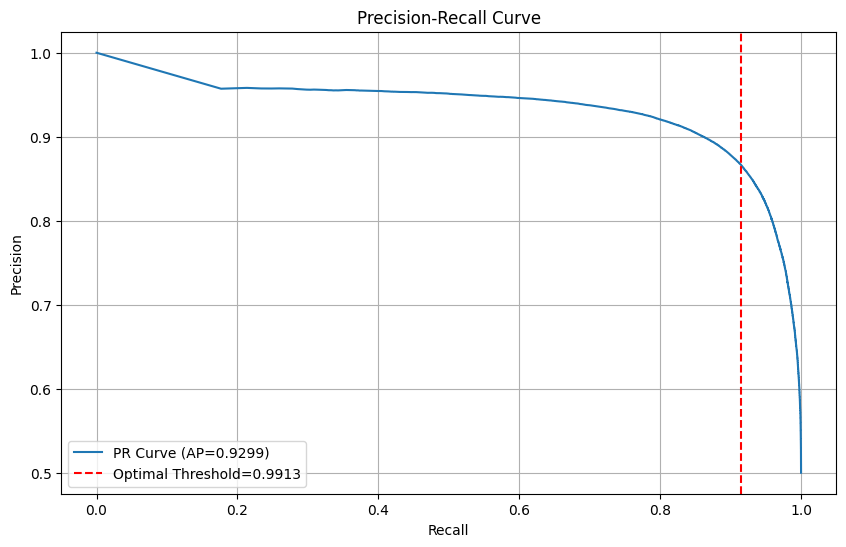


Optimal Threshold: 0.9913
Precision: 0.8671
Recall: 0.9143
F1 Score: 0.8901
Average Precision: 0.9299


In [62]:
# ============================================================================
# Additional Evaluation: Precision-Recall Curve & Optimal Threshold
# ============================================================================

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def find_optimal_threshold_fastest(model, train_val_edge_index, test_df,
                                   fund_to_idx, stock_to_idx, device):
    """
    Find optimal threshold using Precision-Recall curve.
    """
    print("=" * 60)
    print("Finding Optimal Threshold")
    print("=" * 60)
    
    model.eval()
    
    # Prepare test edges
    test_pos_pairs = []
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Preparing test edges"):
        if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
            test_pos_pairs.append([fund_to_idx[row['cik']], stock_to_idx[row['cusip']]])
    
    test_pos_edges = torch.tensor(test_pos_pairs, dtype=torch.long).to(device)
    
    # Sample negative edges
    test_neg_edges = []
    test_pos_set = set((u.item(), v.item()) for u, v in test_pos_edges)
    
    for _ in tqdm(range(len(test_pos_edges)), desc="Sampling negatives"):
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if u != v and (u, v) not in test_pos_set:
            test_neg_edges.append([u, v])
            if len(test_neg_edges) >= len(test_pos_edges):
                break
    
    test_neg_edges = torch.tensor(test_neg_edges[:len(test_pos_edges)], dtype=torch.long).to(device)
    
    # Get predictions
    with torch.no_grad():
        embeddings = model(train_val_edge_index)
        
        pos_u = embeddings[test_pos_edges[:, 0]]
        pos_v = embeddings[test_pos_edges[:, 1]]
        pos_scores = (pos_u * pos_v).sum(dim=1).sigmoid().cpu().numpy()
        
        neg_u = embeddings[test_neg_edges[:, 0]]
        neg_v = embeddings[test_neg_edges[:, 1]]
        neg_scores = (neg_u * neg_v).sum(dim=1).sigmoid().cpu().numpy()
        
        all_scores = np.concatenate([pos_scores, neg_scores])
        all_labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)
    avg_precision = average_precision_score(all_labels, all_scores)
    
    # Find optimal threshold (maximize F1)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f'PR Curve (AP={avg_precision:.4f})')
    plt.axvline(x=recall[optimal_idx], color='r', linestyle='--', 
                label=f'Optimal Threshold={optimal_threshold:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Evaluate with optimal threshold
    pred_labels = (all_scores >= optimal_threshold).astype(int)
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision_opt = precision_score(all_labels, pred_labels)
    recall_opt = recall_score(all_labels, pred_labels)
    f1_opt = f1_score(all_labels, pred_labels)
    
    print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
    print(f"Precision: {precision_opt:.4f}")
    print(f"Recall: {recall_opt:.4f}")
    print(f"F1 Score: {f1_opt:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    
    return optimal_threshold, precision, recall, thresholds

# Run
optimal_threshold, prec, rec, thresh = find_optimal_threshold_fastest(
    model, train_val_edge_index, test_df, fund_to_idx, stock_to_idx, device
)

In [41]:
# Step 2: Prepare Data for LightGCN - Node Mappings

def create_node_mappings(funds, stocks):
    """Create mappings from node IDs to indices for LightGCN."""
    # Map funds to indices [0, len(funds))
    fund_to_idx = {fund: idx for idx, fund in enumerate(funds)}
    
    # Map stocks to indices [len(funds), len(funds) + len(stocks))
    stock_to_idx = {stock: idx + len(funds) for idx, stock in enumerate(stocks)}
    
    # Combined mapping
    node_to_idx = {**fund_to_idx, **stock_to_idx}
    
    return node_to_idx, fund_to_idx, stock_to_idx

# Create mappings (run this before Cell 20)
node_to_idx, fund_to_idx, stock_to_idx = create_node_mappings(funds, stocks)

print(f"✓ Node mappings created")
print(f"  - Funds mapped: {len(fund_to_idx):,}")
print(f"  - Stocks mapped: {len(stock_to_idx):,}")
print(f"  - Total nodes: {len(node_to_idx):,}")

✓ Node mappings created
  - Funds mapped: 7,058
  - Stocks mapped: 2,911
  - Total nodes: 9,969


In [ ]:
# Step 2: Prepare Data for LightGCN (Fastest with Progress Tracking)

def create_node_mappings(funds, stocks):
    """Create mappings from node IDs to indices for LightGCN."""
    fund_to_idx = {fund: idx for idx, fund in enumerate(funds)}
    stock_to_idx = {stock: idx + len(funds) for idx, stock in enumerate(stocks)}
    node_to_idx = {**fund_to_idx, **stock_to_idx}
    
    return node_to_idx, fund_to_idx, stock_to_idx

def graph_to_edge_index_fastest(G, node_to_idx, device):
    """
    Fastest conversion using vectorized operations with progress tracking.
    All tensors are created on CPU then moved to device (faster).
    """
    import time
    start = time.time()
    
    print("=" * 60)
    print("Converting Graph to PyTorch Geometric Format")
    print("=" * 60)
    
    # Get all edges
    print("\n[1/4] Extracting edges from graph...")
    extract_start = time.time()
    edges_data = list(G.edges(data=True))
    num_edges = len(edges_data)
    print(f"     ✓ Extracted {num_edges:,} edges in {time.time() - extract_start:.2f}s")
    
    # Extract u, v, weights (vectorized)
    print("\n[2/4] Processing edge data...")
    process_start = time.time()
    
    with tqdm(total=num_edges, desc="     Processing", unit="edges", unit_scale=True) as pbar:
        u_nodes = [u for u, _, _ in edges_data]
        v_nodes = [v for _, v, _ in edges_data]
        weights_list = [data.get('weight', 1.0) for _, _, data in edges_data]
        pbar.update(num_edges)
    
    print(f"     ✓ Processed in {time.time() - process_start:.2f}s")
    
    # Map to indices (vectorized)
    print("\n[3/4] Mapping nodes to indices...")
    map_start = time.time()
    
    with tqdm(total=num_edges, desc="     Mapping", unit="edges", unit_scale=True) as pbar:
        u_indices = torch.tensor([node_to_idx[u] for u in u_nodes], dtype=torch.long)
        v_indices = torch.tensor([node_to_idx[v] for v in v_nodes], dtype=torch.long)
        weights = torch.tensor(weights_list, dtype=torch.float)
        pbar.update(num_edges)
    
    print(f"     ✓ Mapped in {time.time() - map_start:.2f}s")
    
    # Create bidirectional edges (vectorized)
    print("\n[4/4] Creating bidirectional edges and moving to device...")
    create_start = time.time()
    
    with tqdm(total=1, desc="     Creating tensors") as pbar:
        # Concatenate for bidirectional
        u_bidirectional = torch.cat([u_indices, v_indices])
        v_bidirectional = torch.cat([v_indices, u_indices])
        weights_bidirectional = torch.cat([weights, weights])
        
        # Create edge_index
        edge_index = torch.stack([u_bidirectional, v_bidirectional]).contiguous()
        pbar.update(1)
    
    # Move to device
    with tqdm(total=2, desc="     Moving to device") as pbar:
        edge_index = edge_index.to(device)
        pbar.update(1)
        edge_weights = weights_bidirectional.to(device)
        pbar.update(1)
    
    elapsed = time.time() - start
    print(f"\n     ✓ Completed in {time.time() - create_start:.2f}s")
    
    print("\n" + "=" * 60)
    print("Conversion Complete")
    print("=" * 60)
    print(f"Total time: {elapsed:.2f}s")
    print(f"Speed: {num_edges/elapsed:,.0f} edges/second")
    print(f"Edge index shape: {edge_index.shape} (on {device})")
    print(f"Edge weights shape: {edge_weights.shape} (on {device})")
    print(f"Total bidirectional edges: {edge_index.shape[1]:,}")
    print("=" * 60)
    
    return edge_index, edge_weights

# Create mappings
print("Creating node mappings...")
node_to_idx, fund_to_idx, stock_to_idx = create_node_mappings(funds, stocks)

print(f"✓ Node mappings created")
print(f"  - Funds: {len(fund_to_idx):,}")
print(f"  - Stocks: {len(stock_to_idx):,}")
print(f"  - Total nodes: {len(node_to_idx):,}")

# Convert to PyTorch Geometric format (fastest, on device)
edge_index, edge_weights = graph_to_edge_index_fastest(G_bipartite, node_to_idx, device)

Creating node mappings...
✓ Node mappings created
  - Funds: 7,058
  - Stocks: 2,911
  - Total nodes: 9,969
Converting Graph to PyTorch Geometric Format

[1/4] Extracting edges from graph...
     ✓ Extracted 1,082,909 edges in 2.28s

[2/4] Processing edge data...


     Processing: 100%|██████████| 1.08M/1.08M [00:00<00:00, 2.76Medges/s]


     ✓ Processed in 0.39s

[3/4] Mapping nodes to indices...


     Mapping: 100%|██████████| 1.08M/1.08M [00:00<00:00, 2.99Medges/s]


     ✓ Mapped in 0.36s

[4/4] Creating bidirectional edges and moving to device...


     Moving to device: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


     ✓ Completed in 0.36s

Conversion Complete
Total time: 3.40s
Speed: 318,107 edges/second
Edge index shape: torch.Size([2, 2165818]) (on cuda)
Edge weights shape: torch.Size([2165818]) (on cuda)
Total bidirectional edges: 2,165,818


In [ ]:
# Step 3: Create PyTorch Geometric Data Object (Fastest with Progress)

def create_pyg_data_fastest(edge_index, edge_weights, num_nodes, device, node_features=None):
    """
    Create PyTorch Geometric Data object on specified device.
    Fastest method with progress tracking.
    """
    import time
    start = time.time()
    
    print("=" * 60)
    print("Creating PyTorch Geometric Data Object")
    print("=" * 60)
    
    # Create node features
    print("\n[1/2] Creating node features...")
    feature_start = time.time()
    
    if node_features is None:
        # Create random features directly on device (faster)
        with tqdm(total=1, desc="     Generating features") as pbar:
            node_features = torch.randn(num_nodes, 64, device=device)
            pbar.update(1)
    else:
        # Move existing features to device
        with tqdm(total=1, desc="     Moving features to device") as pbar:
            node_features = node_features.to(device)
            pbar.update(1)
    
    print(f"     ✓ Created in {time.time() - feature_start:.2f}s")
    print(f"     Feature shape: {node_features.shape}")
    
    # Create Data object
    print("\n[2/2] Creating Data object...")
    data_start = time.time()
    
    with tqdm(total=1, desc="     Assembling data") as pbar:
        data = Data(
            x=node_features,
            edge_index=edge_index,  # Already on device
            edge_attr=edge_weights  # Already on device
        )
        pbar.update(1)
    
    elapsed = time.time() - start
    print(f"     ✓ Created in {time.time() - data_start:.2f}s")
    
    print("\n" + "=" * 60)
    print("Data Object Created")
    print("=" * 60)
    print(f"Total time: {elapsed:.2f}s")
    print(f"Device: {device}")
    print(f"Node features shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"Edge attributes shape: {data.edge_attr.shape}")
    print(f"Total nodes: {num_nodes:,}")
    print("=" * 60)
    
    return data

# Create data object (fastest, on device)
num_nodes = len(funds) + len(stocks)
data = create_pyg_data_fastest(edge_index, edge_weights, num_nodes, device)

print(f"\n✓ PyG Data object ready for training")

Creating PyTorch Geometric Data Object

[1/2] Creating node features...


     Generating features: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


     ✓ Created in 0.14s
     Feature shape: torch.Size([9969, 64])

[2/2] Creating Data object...


     Assembling data: 100%|██████████| 1/1 [00:00<00:00, 7825.19it/s]

     ✓ Created in 0.00s

Data Object Created
Total time: 0.14s
Device: cuda
Node features shape: torch.Size([9969, 64])
Edge index shape: torch.Size([2, 2165818])
Edge attributes shape: torch.Size([2165818])
Total nodes: 9,969

✓ PyG Data object ready for training


## Model Train

In [ ]:
# Step 4: LightGCN Model Definition (Fastest with Progress)

import torch.nn as nn
from torch_geometric.nn import GCNConv

class LightGCN(nn.Module):
    """
    LightGCN model for bipartite graph recommendation.
    Simplified version without feature transformation.
    """
    def __init__(self, num_nodes, embedding_dim=64, num_layers=3):
        super(LightGCN, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.normal_(self.embedding.weight, std=0.1)
        
        # GCN layers
        self.convs = nn.ModuleList([
            GCNConv(embedding_dim, embedding_dim, improved=False, cached=False)
            for _ in range(num_layers)
        ])
    
    def forward(self, edge_index):
        """Forward pass through LightGCN layers."""
        x = self.embedding.weight
        
        # Aggregate embeddings from all layers
        embeddings = [x]
        
        for conv in self.convs:
            x = conv(x, edge_index)
            embeddings.append(x)
        
        # Average all layer embeddings (LightGCN approach)
        final_embedding = torch.stack(embeddings, dim=0).mean(dim=0)
        
        return final_embedding

def initialize_model_fastest(num_nodes, embedding_dim, num_layers, device):
    """
    Initialize LightGCN model and move to device with progress tracking.
    """
    import time
    start = time.time()
    
    print("=" * 60)
    print("Initializing LightGCN Model")
    print("=" * 60)
    
    print("\n[1/2] Creating model...")
    with tqdm(total=1, desc="     Building model") as pbar:
        model = LightGCN(num_nodes=num_nodes, embedding_dim=embedding_dim, num_layers=num_layers)
        pbar.update(1)
    
    print("\n[2/2] Moving to device...")
    with tqdm(total=1, desc=f"     Moving to {device}") as pbar:
        model = model.to(device)
        pbar.update(1)
    
    elapsed = time.time() - start
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print("\n" + "=" * 60)
    print("Model Initialized")
    print("=" * 60)
    print(f"Total time: {elapsed:.2f}s")
    print(f"Device: {device}")
    print(f"Embedding dimension: {embedding_dim}")
    print(f"Number of layers: {num_layers}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print("=" * 60)
    
    return model

# Initialize model (fastest, on device)
model = initialize_model_fastest(
    num_nodes=num_nodes,
    embedding_dim=64,
    num_layers=3,
    device=device
)

print(f"\n✓ LightGCN model ready for training")

Initializing LightGCN Model

[1/2] Creating model...


     Building model: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]



[2/2] Moving to device...


     Moving to cuda: 100%|██████████| 1/1 [00:00<00:00, 33.49it/s]


Model Initialized
Total time: 0.13s
Device: cuda
Embedding dimension: 64
Number of layers: 3
Total parameters: 650,496
Trainable parameters: 650,496

✓ LightGCN model ready for training


In [ ]:

# Step 5: Training Setup (Fastest with Progress Tracking)

def create_positive_negative_pairs_fastest(edge_index, num_nodes, device, num_negatives=1):
    """
    Create positive and negative edge pairs for training.
    Optimized with progress tracking and efficient sampling.
    """
    import time
    start = time.time()
    
    print("=" * 60)
    print("Creating Training Pairs")
    print("=" * 60)
    
    # Extract positive edges
    print("\n[1/3] Extracting positive edges...")
    pos_start = time.time()
    
    with tqdm(total=1, desc="     Extracting") as pbar:
        pos_edges = edge_index.t().tolist()
        pbar.update(1)
    
    pos_count = len(pos_edges)
    print(f"     ✓ Extracted {pos_count:,} positive edges in {time.time() - pos_start:.2f}s")
    
    # Create positive set for fast lookup
    print("\n[2/3] Creating positive edge set...")
    set_start = time.time()
    
    with tqdm(total=1, desc="     Building set") as pbar:
        pos_set = set((u, v) for u, v in pos_edges)
        pbar.update(1)
    
    print(f"     ✓ Created set in {time.time() - set_start:.2f}s")
    
    # Sample negative edges
    print(f"\n[3/3] Sampling {num_negatives}x negative edges...")
    neg_start = time.time()
    
    target_neg_count = pos_count * num_negatives
    neg_edges = []
    
    # Use numpy for faster random sampling
    with tqdm(total=target_neg_count, desc="     Sampling negatives", unit="edges", unit_scale=True) as pbar:
        attempts = 0
        max_attempts = target_neg_count * 10  # Safety limit
        
        while len(neg_edges) < target_neg_count and attempts < max_attempts:
            # Batch sampling for efficiency
            batch_size = min(10000, target_neg_count - len(neg_edges))
            u_batch = np.random.randint(0, num_nodes, size=batch_size)
            v_batch = np.random.randint(0, num_nodes, size=batch_size)
            
            for u, v in zip(u_batch, v_batch):
                if (u, v) not in pos_set and u != v:
                    neg_edges.append([int(u), int(v)])
                    if len(neg_edges) >= target_neg_count:
                        break
            
            attempts += batch_size
            pbar.update(min(batch_size, target_neg_count - len(neg_edges)))
    
    neg_count = len(neg_edges)
    print(f"     ✓ Sampled {neg_count:,} negative edges in {time.time() - neg_start:.2f}s")
    
    # Convert to tensors and move to device
    print("\n[4/4] Creating tensors and moving to device...")
    tensor_start = time.time()
    
    with tqdm(total=2, desc="     Creating tensors") as pbar:
        pos_tensor = torch.tensor(pos_edges, dtype=torch.long).to(device)
        pbar.update(1)
        neg_tensor = torch.tensor(neg_edges, dtype=torch.long).to(device)
        pbar.update(1)
    
    elapsed = time.time() - start
    print(f"     ✓ Completed in {time.time() - tensor_start:.2f}s")
    
    print("\n" + "=" * 60)
    print("Training Pairs Created")
    print("=" * 60)
    print(f"Total time: {elapsed:.2f}s")
    print(f"Positive edges: {pos_count:,}")
    print(f"Negative edges: {neg_count:,}")
    print(f"Ratio: {neg_count/pos_count:.2f}x")
    print(f"Device: {device}")
    print("=" * 60)
    
    return pos_tensor, neg_tensor

# Create training pairs (fastest, on device)
pos_edges, neg_edges = create_positive_negative_pairs_fastest(edge_index, num_nodes, device, num_negatives=1)

print(f"\n✓ Training pairs ready on {device}")

Creating Training Pairs

[1/3] Extracting positive edges...


     Extracting: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


     ✓ Extracted 2,165,818 positive edges in 0.82s

[2/3] Creating positive edge set...


     Building set: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


     ✓ Created set in 2.05s

[3/3] Sampling 1x negative edges...


     Sampling negatives: 2.20Medges [00:04, 486kedges/s]                         


     ✓ Sampled 2,165,818 negative edges in 4.53s

[4/4] Creating tensors and moving to device...


     Creating tensors: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


     ✓ Completed in 0.69s

Training Pairs Created
Total time: 8.09s
Positive edges: 2,165,818
Negative edges: 2,165,818
Ratio: 1.00x
Device: cuda

✓ Training pairs ready on cuda


In [ ]:
# Step 6: Training Loop (Fastest with Progress Tracking)

def bpr_loss(pos_scores, neg_scores):
    """Bayesian Personalized Ranking loss."""
    return -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()

def train_lightgcn_fastest(model, edge_index, pos_edges, neg_edges, device, epochs=50, lr=0.001):
    """
    Train LightGCN model using BPR loss on specified device.
    Optimized with progress tracking and early stopping.
    """
    import time
    start = time.time()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    losses = []
    best_loss = float('inf')
    patience = 10
    no_improve = 0
    
    print("=" * 60)
    print("Training LightGCN")
    print("=" * 60)
    print(f"Device: {device}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {lr}")
    print(f"Positive edges: {len(pos_edges):,}")
    print(f"Negative edges: {len(neg_edges):,}")
    print("=" * 60)
    
    # Training loop with progress bar
    with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
        for epoch in range(epochs):
            epoch_start = time.time()
            
            optimizer.zero_grad()
            
            # Forward pass
            embeddings = model(edge_index)
            
            # Positive scores
            pos_u = embeddings[pos_edges[:, 0]]
            pos_v = embeddings[pos_edges[:, 1]]
            pos_scores = (pos_u * pos_v).sum(dim=1)
            
            # Negative scores
            neg_u = embeddings[neg_edges[:, 0]]
            neg_v = embeddings[neg_edges[:, 1]]
            neg_scores = (neg_u * neg_v).sum(dim=1)
            
            # Loss
            loss = bpr_loss(pos_scores, neg_scores)
            loss.backward()
            optimizer.step()
            
            loss_val = loss.item()
            losses.append(loss_val)
            
            # Early stopping check
            if loss_val < best_loss:
                best_loss = loss_val
                no_improve = 0
            else:
                no_improve += 1
            
            epoch_time = time.time() - epoch_start
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss_val:.4f}',
                'best': f'{best_loss:.4f}',
                'time': f'{epoch_time:.2f}s'
            })
            pbar.update(1)
            
            # Early stopping
            if no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break
    
    elapsed = time.time() - start
    
    print("\n" + "=" * 60)
    print("Training Complete")
    print("=" * 60)
    print(f"Total time: {elapsed:.2f}s ({elapsed/60:.2f} min)")
    print(f"Epochs completed: {len(losses)}")
    print(f"Final loss: {losses[-1]:.4f}")
    print(f"Best loss: {best_loss:.4f}")
    print(f"Average time per epoch: {elapsed/len(losses):.2f}s")
    print("=" * 60)
    
    return losses, embeddings

# Train model (fastest, on device)
print(f"Starting training on {device}...")
losses, final_embeddings = train_lightgcn_fastest(
    model, edge_index, pos_edges, neg_edges, device, 
    epochs=50, lr=0.001
)

print(f"\n✓ Training completed")
print(f"  - Final loss: {losses[-1]:.4f}")
print(f"  - Embeddings shape: {final_embeddings.shape} (on {device})")

Starting training on cuda...
Training LightGCN
Device: cuda
Epochs: 50
Learning rate: 0.001
Positive edges: 2,165,818
Negative edges: 2,165,818


Training:  80%|████████  | 40/50 [00:19<00:04,  2.07epoch/s, loss=0.1858, best=0.1517, time=0.29s]


Early stopping at epoch 40 (no improvement for 10 epochs)

Training Complete
Total time: 19.33s (0.32 min)
Epochs completed: 40
Final loss: 0.1858
Best loss: 0.1517
Average time per epoch: 0.48s

✓ Training completed
  - Final loss: 0.1858
  - Embeddings shape: torch.Size([9969, 64]) (on cuda)
